# LOWESS Smoother

This notebook introduces the LOWESS smoother in the `nonparametric` package. LOWESS performs weighted local linear fits.

We generated some non-linear data and perform a LOWESS fit, then compute a 95% confidence interval around the LOWESS fit by performing bootstrap resampling.

In [1]:
import numpy as np
import pylab
import seaborn as sns
import statsmodels.api as sm

sns.set_style("darkgrid")
pylab.rc("figure", figsize=(16, 8))
pylab.rc("font", size=14)

In [2]:
# Seed for consistency
np.random.seed(1)

In [3]:
# Generate data looking like cosine
x = np.random.uniform(0, 4 * np.pi, size=200)
y = np.cos(x) + np.random.random(size=len(x))

# Compute a lowess smoothing of the data
smoothed = sm.nonparametric.lowess(exog=x, endog=y, frac=0.2)

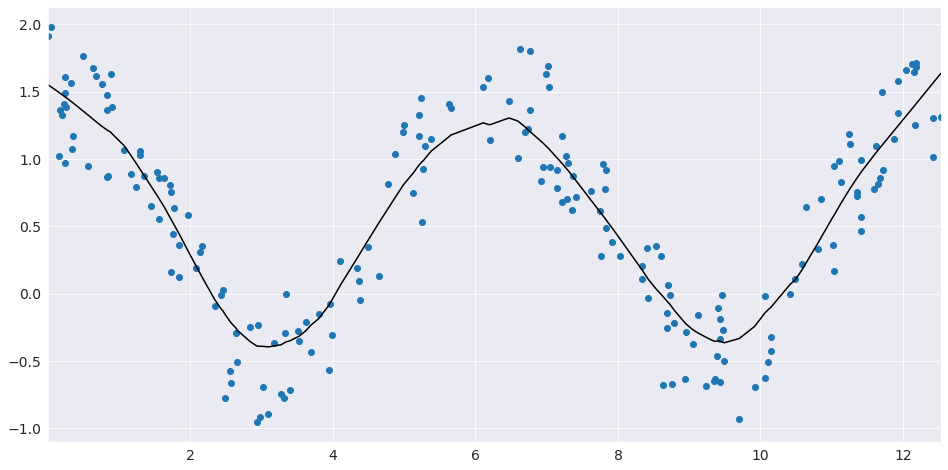

In [4]:
# Plot the fit line
fig, ax = pylab.subplots()

ax.scatter(x, y)
ax.plot(smoothed[:, 0], smoothed[:, 1], c="k")
pylab.autoscale(enable=True, axis="x", tight=True)

## Confidence interval

Now that we have performed a fit, we may want to know how precise it is. Bootstrap resampling gives one
way of estimating confidence intervals around a LOWESS fit by recomputing the LOWESS fit for a large number
of random resamplings from our data.

In [5]:
# Now create a bootstrap confidence interval around the a LOWESS fit


def lowess_with_confidence_bounds(
    x, y, eval_x, N=200, conf_interval=0.95, lowess_kw=None
):
    """
    Perform Lowess regression and determine a confidence interval by bootstrap resampling
    """
    # Lowess smoothing
    smoothed = sm.nonparametric.lowess(exog=x, endog=y, xvals=eval_x, **lowess_kw)

    # Perform bootstrap resamplings of the data
    # and  evaluate the smoothing at a fixed set of points
    smoothed_values = np.empty((N, len(eval_x)))
    for i in range(N):
        sample = np.random.choice(len(x), len(x), replace=True)
        sampled_x = x[sample]
        sampled_y = y[sample]

        smoothed_values[i] = sm.nonparametric.lowess(
            exog=sampled_x, endog=sampled_y, xvals=eval_x, **lowess_kw
        )

    # Get the confidence interval
    sorted_values = np.sort(smoothed_values, axis=0)
    bound = int(N * (1 - conf_interval) / 2)
    bottom = sorted_values[bound - 1]
    top = sorted_values[-bound]

    return smoothed, bottom, top


# Compute the 95% confidence interval
eval_x = np.linspace(0, 4 * np.pi, 31)
smoothed, bottom, top = lowess_with_confidence_bounds(
    x, y, eval_x, lowess_kw={"frac": 0.1}
)

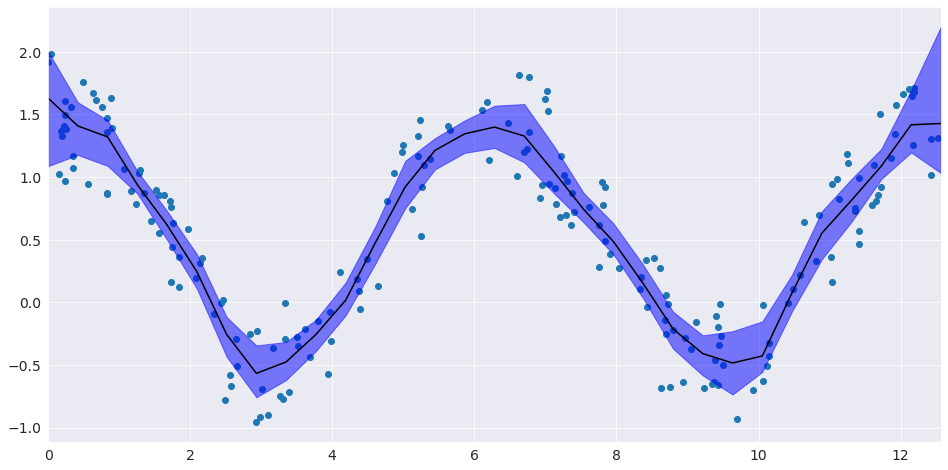

In [6]:
# Plot the confidence interval and fit
fig, ax = pylab.subplots()
ax.scatter(x, y)
ax.plot(eval_x, smoothed, c="k")
ax.fill_between(eval_x, bottom, top, alpha=0.5, color="b")
pylab.autoscale(enable=True, axis="x", tight=True)